In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

from npiv import iv_simulator, custom_objectives, model_wrapper

In [2]:
# 0. random data.  price is endogenous, instrument is this 
n = 10000 # number of observations
d = 2 # dimensionality of the exogenous regressors in x
    
ivsim = iv_simulator.IVSimulator(num_exog_x_cols=d)
df = ivsim.generate_data(num_obs=n)
df['id'] = np.arange(n)

In [3]:
df.head()

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
0,-1.085631,0.997345,-2.911176,-0.062427,0.358411,0.075597,0.434008,-3.001299,0
1,0.282978,-1.506295,-3.156704,-0.865015,-0.484068,0.055417,-0.428650,0.365224,1
2,-0.578600,1.651437,-1.748911,0.758610,1.606738,-0.025814,1.580924,-1.169309,2
3,-2.426679,-0.428913,-3.764864,-2.019208,-1.710488,-0.012513,-1.723001,4.389678,3
4,1.265936,-0.866740,-4.289064,0.282274,0.547740,-0.091385,0.456354,-0.240278,4


In [4]:
print(ivsim.exog_x_cols, ivsim.endog_x_col, ivsim.instrument_col, ivsim.y_col)
display(ivsim.log_cost_coefs)
display(ivsim.log_sales_coefs)
display(df.describe())

['x_0', 'x_1'] log_price instrument log_sales


x_0    0.707107
x_1    0.707107
dtype: float64

x_0          0.707107
x_1          0.707107
log_price   -4.000000
dtype: float64

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.018369,0.001719,-3.998095,0.014204,0.424120,0.000942,0.425062,-1.263862,4999.50000
std,1.003899,0.996794,1.609220,1.013633,1.058928,0.057623,1.060207,3.620433,2886.89568
min,-3.801378,-3.685499,-6.798997,-3.492599,-3.127753,-0.099983,-3.132122,-17.948572,0.00000
25%,-0.666906,-0.686832,-5.394813,-0.676062,-0.306594,-0.048520,-0.304092,-3.116390,2499.75000
50%,0.014632,0.009468,-4.007687,0.001468,0.411439,0.001735,0.409161,-1.363713,4999.50000
75%,0.683905,0.681603,-2.616799,0.696894,1.137529,0.050727,1.136885,0.653906,7499.25000
max,3.676205,4.068097,-1.200855,3.628798,4.165641,0.099975,4.088933,14.160886,9999.00000


In [5]:
# 4. now compute some true quantiles
log_price_qtl_cols = []
interval = .1
qtls = np.arange(0,1,interval) + interval/2
print("computing these conditional quantiles of log price: {}".format(qtls))
for qtl in qtls:
    qcol = 'log_price_qtl_{:.3f}'.format(qtl)
    df[qcol] = ivsim.compute_log_price_quantile_given_cost_and_instrument(df['unobserved_log_cost'], df['instrument'], qtl)
    log_price_qtl_cols.append(qcol)
print("these are the relevant columns: {}".format(log_price_qtl_cols))

computing these conditional quantiles of log price: [ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]
these are the relevant columns: ['log_price_qtl_0.050', 'log_price_qtl_0.150', 'log_price_qtl_0.250', 'log_price_qtl_0.350', 'log_price_qtl_0.450', 'log_price_qtl_0.550', 'log_price_qtl_0.650', 'log_price_qtl_0.750', 'log_price_qtl_0.850', 'log_price_qtl_0.950']


In [6]:
# 5. construct data for doing deepiv with these true quantiles
#    this will involve just duplicating the data a bunch of times,
#    each time for each quantile of log price
dfs_to_concat = []
for c in log_price_qtl_cols:
    tmp_df = df[['id']+ivsim.exog_x_cols+[c]+[ivsim.y_col]].rename(columns={c:'log_price_synthetic'})
    dfs_to_concat.append(tmp_df)
df_long = pd.concat(dfs_to_concat).reset_index(drop=True)

In [7]:
# 6. check linear custom objective still works here just to be sure
from scipy.optimize import minimize
# now actually optimize it. takes maybe a minute to finish?
tmp_xcols = ivsim.exog_x_cols+['log_price_synthetic']
min_output = minimize(fun = custom_objectives.grouped_sse_loss_linear, 
                      x0=np.zeros(shape=len(tmp_xcols)+1), 
                      args = (df_long, tmp_xcols, ivsim.y_col, 'id'))
# compare with truth.  doesn't look too bad.
pd.DataFrame({'true coefs': ivsim.log_sales_coefs, 'linear NPIV coefs':min_output.x[1:]})

,true coefs,linear NPIV coefs
x_0,0.707107,0.536132
x_1,0.707107,0.514787
log_price,-4.000000,-3.770611


# impact of regularization

In [18]:
def evaluate_regularization_impact(min_gain_to_split=0):
    # ok, now let's try the custom objective
    num_iters = 10000
    print_every = max(num_iters//20, 10)
    print(num_iters, print_every)

    # try training
    params = {
        'num_threads':4,
        'objective': None,
        'metric': None,
        'num_leaves': 5,
        'learning_rate': 0.2,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'max_delta_step':.1,
        'min_gain_to_split':min_gain_to_split,
    }
    eval_results={}
    gbm2 = lgb.train(params, train_set=dat_train, valid_sets=[dat_train, dat_val], valid_names=['train', 'val'],
                    num_boost_round=num_iters, verbose_eval=print_every,
                    fobj = lambda preds, dataset: \
                             custom_objectives.grouped_sse_loss_grad_hess(preds, dataset.label, dataset.grouper),
                    feval = lambda preds, dataset: \
                                 ('grouped sse',
                                    custom_objectives.grouped_sse_loss(preds, dataset.label, dataset.grouper),
                                    False),
                     callbacks=[lgb.record_evaluation(eval_results)]
                    )

    # look at some marginal effects
    wrapped_gbm2 = model_wrapper.ModelWrapper(gbm2)
    marginal_fx = wrapped_gbm2.marginal_effect_plots(df_test, plot=False)
    marginal_fx.groupby('feature name').describe().transpose()

    # generate time series of marginal effects
    dfs_to_concat = []
    for num_iteration in np.linspace(1,num_iters, 50, dtype=int):
    #     print(num_iteration)
        mfx = wrapped_gbm2.marginal_effect_plots(df_test, plot=False, predict_kwargs={'num_iteration':num_iteration})
        tmp_df = mfx.groupby('feature name').describe().transpose().reset_index(level=0,drop=True)\
                    .reset_index().rename(columns={'index':'stat'})
        tmp_df.columns.name=None
        tmp_df['num_iteration'] = num_iteration
        tmp_df.set_index(['num_iteration', 'stat'], inplace=True)
    #     display(tmp_df)
        dfs_to_concat.append(tmp_df)
    desc_df = pd.concat(dfs_to_concat)

    # plot stuff
    fig, axes = plt.subplots(nrows=desc_df.shape[1]+1, ncols=1, figsize=(10, (desc_df.shape[1]+1)*1.5), sharex=True)
    # plot performance
    ax = axes[0]
    ax.grid()
    perfs = eval_results['val']['grouped sse']
    best_num_trees = np.argmin(perfs)
    ax.plot(eval_results['val']['grouped sse'], color='#555555')
    ax.axvline(best_num_trees, color='blue', linewidth=1)
    ax.set_yscale('log')
    ax.set_title("validation set performance, blue=best")
    # plot marginal effects
    for i,c in enumerate(desc_df.columns):
        tmp_df = desc_df.loc[pd.IndexSlice[:, ['mean', 'min', 'max', '25%', '75%']],c].unstack()
        ax = axes[i+1]
        ax.grid()
        # plot the true marginal effects
        if c=='log_price_synthetic':
            true_mfx = ivsim.log_sales_coefs.loc['log_price']
        else:
            true_mfx = ivsim.log_sales_coefs.loc[c]
        ax.axhline(true_mfx, color='red', linewidth=1)
        ax.axvline(best_num_trees, color='blue', linewidth=1)
        # plot the model implied marignal effects
        ax.plot(tmp_df['mean'], color='black', linestyle='-')
        ax.plot(tmp_df['25%'], color='black', linestyle='-.')
        ax.plot(tmp_df['75%'], color='black', linestyle='-.')
        ax.set_title('mean and quartiles of marginal effects of `{}`, red = truth'.format(c))
    plt.xlabel("number of trees trained")
    plt.tight_layout()

10000 500
[500]	train's grouped sse: 1.70012e+06	val's grouped sse: 771468
[1000]	train's grouped sse: 1.60975e+06	val's grouped sse: 810034
[1500]	train's grouped sse: 1.57591e+06	val's grouped sse: 826012
[2000]	train's grouped sse: 1.55675e+06	val's grouped sse: 839410
[2500]	train's grouped sse: 1.54578e+06	val's grouped sse: 851011
[3000]	train's grouped sse: 1.53906e+06	val's grouped sse: 857091
[3500]	train's grouped sse: 1.53373e+06	val's grouped sse: 861672
[4000]	train's grouped sse: 1.53035e+06	val's grouped sse: 865522
[4500]	train's grouped sse: 1.52777e+06	val's grouped sse: 868482
[5000]	train's grouped sse: 1.52574e+06	val's grouped sse: 871395
[5500]	train's grouped sse: 1.52371e+06	val's grouped sse: 870014
[6000]	train's grouped sse: 1.52182e+06	val's grouped sse: 869794
[6500]	train's grouped sse: 1.52022e+06	val's grouped sse: 868871
[7000]	train's grouped sse: 1.51899e+06	val's grouped sse: 870541
[7500]	train's grouped sse: 1.51812e+06	val's grouped sse: 870432
[

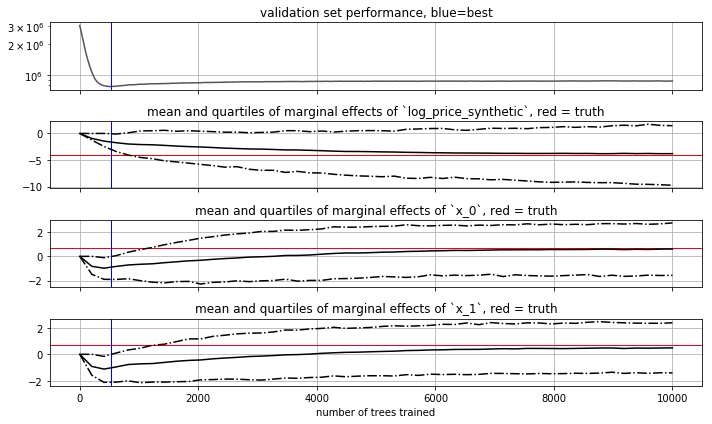

In [19]:
evaluate_regularization_impact(min_gain_to_split=0)

10000 500
[500]	train's grouped sse: 1.71516e+06	val's grouped sse: 766952
[1000]	train's grouped sse: 1.61916e+06	val's grouped sse: 804936
[1500]	train's grouped sse: 1.58108e+06	val's grouped sse: 824057
[2000]	train's grouped sse: 1.56095e+06	val's grouped sse: 838082
[2500]	train's grouped sse: 1.54885e+06	val's grouped sse: 846703
[3000]	train's grouped sse: 1.54128e+06	val's grouped sse: 855646
[3500]	train's grouped sse: 1.53615e+06	val's grouped sse: 858526
[4000]	train's grouped sse: 1.53253e+06	val's grouped sse: 865416
[4500]	train's grouped sse: 1.52952e+06	val's grouped sse: 865762
[5000]	train's grouped sse: 1.52709e+06	val's grouped sse: 868710
[5500]	train's grouped sse: 1.5253e+06	val's grouped sse: 868408
[6000]	train's grouped sse: 1.52363e+06	val's grouped sse: 868588
[6500]	train's grouped sse: 1.52193e+06	val's grouped sse: 871259
[7000]	train's grouped sse: 1.5208e+06	val's grouped sse: 869113
[7500]	train's grouped sse: 1.51956e+06	val's grouped sse: 872028
[80

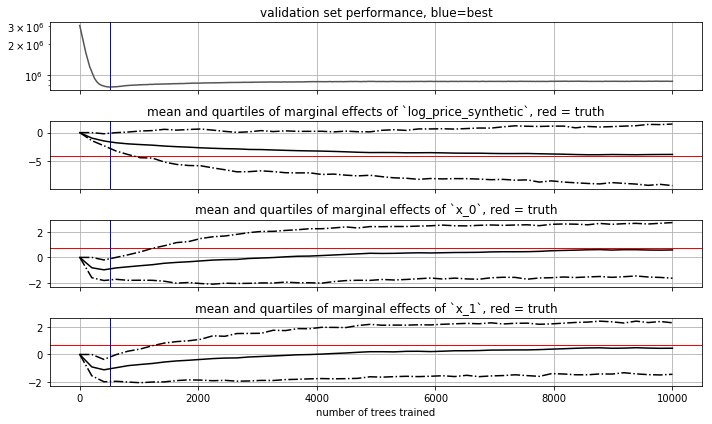

In [20]:
evaluate_regularization_impact(min_gain_to_split=100)

10000 500
[500]	train's grouped sse: 1.72203e+06	val's grouped sse: 766521
[1000]	train's grouped sse: 1.62996e+06	val's grouped sse: 800092
[1500]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[2000]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[2500]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[3000]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[3500]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[4000]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[4500]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[5000]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[5500]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[6000]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[6500]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[7000]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[7500]	train's grouped sse: 1.6062e+06	val's grouped sse: 808764
[8000]	train's

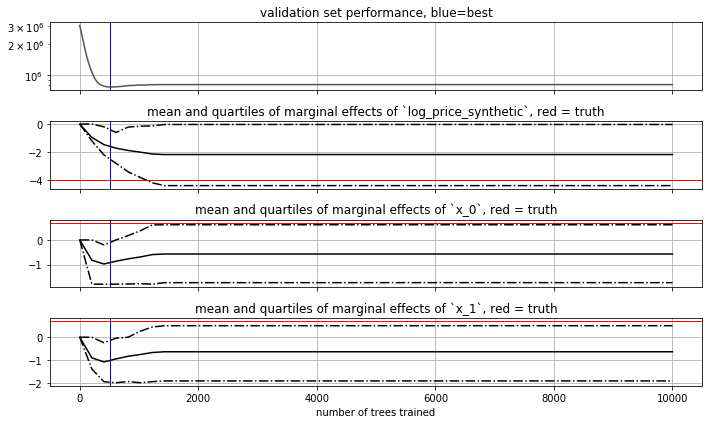

In [21]:
evaluate_regularization_impact(min_gain_to_split=300)